In [1]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from spglm.iwls import _compute_betas_gwr, iwls  
from spglm.family import Gaussian
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from statsmodels.api import OLS

import warnings
warnings.filterwarnings('ignore')

np.set_printoptions(precision=3, suppress=True)

### Data Generating Process

In [2]:
# Simulate S1 and S2
def simulate_S1_S2(num_points1, num_points2):
    np.random.seed(26)
    locations1 = np.random.rand(num_points1, 2) * 100
    centers = [(30, 30), (70, 70), (30, 70), (70, 30)]
    locations2, _ = make_blobs(n_samples=num_points2, centers=centers, cluster_std=10.0, random_state=26)
    locations2 = np.clip(locations2, 0, 100)
    s1 = np.random.normal(50, 20, num_points1)
    s2 = np.random.normal(100, 50, num_points2)
    return s1, locations1, s2, locations2

S1, loc1, S2, loc2 = simulate_S1_S2(200, 350)

# Create beta surface (uniform or local) uniform by default
def create_beta_surface(locations, complexity='uniform'):
    x, y = locations[:, 0], locations[:, 1]
    if complexity == 'uniform':
        B = x / 10 + y / 10
    elif complexity == 'local':
        B = np.sin(x/10) * np.cos(y/10) + (x-50)**2/100 + (y-50)**2/100
    return B
    
# Create the surface with high heterogeneity
def high_heterogeneity(locations):
    # Normalize x and y to the range [0, 1]
    x_min, x_max = np.min(locations[:,0]), np.max(locations[:,0])
    y_min, y_max = np.min(locations[:,1]), np.max(locations[:,1])
    
    x_locations_norm = (locations[:,0] - x_min) / (x_max - x_min)
    y_locations_norm = (locations[:,1] - y_min) / (y_max - y_min)
    
    # Create the surface with high heterogeneity
    # This is similar to the β1 surface in the paper
    surface = 1 + 1/324 * (36*(6*x_locations_norm-2)**2) * (36*(6*y_locations_norm-2)**2)
    
    return surface

# Create constant surface with uniform heterogeneity
def uniform(locations):
    # Create the surface with low heterogeneity
    # This is similar to the β2 surface in the paper, but with even less variation
    surface = np.full(len(locations), 5)
    
    return surface

# Define true beta surface
B = create_beta_surface(loc1, complexity='uniform')

# Generate y values
nbrs_S2 = NearestNeighbors(n_neighbors=35).fit(loc2)
smoothed_S2_to_S1 = np.zeros(len(S1))
for i in range(len(S1)):
    distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc1[i]])
    smoothed_S2_to_S1[i] = np.mean(S2[indices_S1_to_S2[0]])
    

y = B * smoothed_S2_to_S1

In [3]:
# Gaussian family initialization
family = Gaussian()

In [4]:
def calculate_aicc_rss(n, RSS, tr_S):
    """GWR-style AICc calculation using RSS and trace of the hat matrix (tr_S)."""
    # aicc = (n * np.log((RSS)/(n-tr_S))) + (n * np.log(2*np.pi)) + (n*((n+tr_S)/(n-2-tr_S)))
    term1 = 2 * n * np.log(RSS / n)
    term2 = n * np.log(2 * np.pi)
    term3 = n * ((n + tr_S) / (n - 2 - tr_S))
    
    aicc = term1 + term2 + term3
    return aicc
    
def calculate_aicc(n, log_likelihood, tr_S):
    """GWR-style AICc calculation using log-likelihood and trace of the hat matrix (tr_S)."""
    aic = -2 * log_likelihood + 2 * (tr_S + 1)
    aicc = aic + (2 * tr_S * (tr_S + 1)) / (n - tr_S - 1)
    return aicc

def log_likelihood_gaussian(residuals, n):
    """Calculate log-likelihood for Gaussian model."""
    sigma2 = np.sum(residuals**2) / n
    log_likelihood = -0.5 * n * (np.log(2 * np.pi * sigma2) + 1)
    return log_likelihood
    

def plot_true_and_recovered(true, recovered, coord):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(coord[:,0], coord[:, 1], c=true, cmap='Reds', alpha=0.6)
    plt.xlabel('Index')
    plt.ylabel('True B Values')
    plt.colorbar(label='Beta Value')
    plt.title('True B Values')
    
    plt.subplot(1, 2, 2)
    plt.scatter(coord[:,0], coord[:, 1], c=recovered, cmap='Reds', alpha=0.6)
    plt.xlabel('Index')
    plt.ylabel('recovered B Values')
    plt.colorbar(label='Beta Value')
    plt.title('recovered B Values')
    
    plt.tight_layout()
    plt.show()
    

In [5]:
def perform_local_regression(n_neighbor_est, loc1, loc2, S2, y):
    recovered_betas = np.zeros(len(S1))
    residuals = np.zeros(len(S1))
    N = len(S1)
    
    resid_SS = []
    R = np.zeros((N, N))
    S = np.zeros((N, N))

    for i in range(len(S1)):
        # Find neighbors in S2 for current S1_i for smoothing
        nbrs_S2 = NearestNeighbors(n_neighbors=n_neighbor_est).fit(loc2)
        distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc1[i]])
        
        local_X = []
        weights_X = []
        
        # Smooth S2 onto S1 within the local regression function
        for j, neighbor_index_S2 in enumerate(indices_S1_to_S2[0]):
            dist_j_to_i = distances_S1_to_S2[0][j]
            weight = np.exp(-0.5 * (dist_j_to_i / 10)**2)
            local_X.append(S2[neighbor_index_S2])
            weights_X.append(weight)

        local_X = np.array(local_X)
        weights_X = np.array(weights_X)
        weighted_X_i = np.sum(local_X * weights_X) / np.sum(weights_X)
        

        # Local regression using weighted S2 data at S1_i
        nbrs_S1 = NearestNeighbors(n_neighbors=n_neighbor_est).fit(loc1)
        distances, indices = nbrs_S1.kneighbors([loc1[i]])

        y_neighbors = y[indices[0]].reshape(-1, 1)
        X_neighbors = weighted_X_i * np.ones(len(indices[0])).reshape(-1, 1)

        weights_y = np.exp(-0.5 * (distances[0] / 10)**2).reshape(-1, 1)

        rslt = iwls(y_neighbors, X_neighbors, family, None, None, None, 1.0e-5, 20, wi=weights_y)

        recovered_betas[i] = rslt[0]
    
        ri = np.dot(X_neighbors, rslt[5])

    R[i, indices[0]] = ri[0]
    S[i, indices[0]] = ri[0] * rslt[4].flatten()
        
    y_pred_i = np.dot(X_neighbors[0], rslt[0])
    
    residuals[i] = y[i] - y_pred_i
    
    RSS = np.sum(residuals**2)
    resid_SS.append(RSS)
    
    # Calculate trace of S
    tr_S = np.trace(S)
    

    # log_likelihood = log_likelihood_gaussian(residuals, len(S1))
    # aicc = calculate_aicc(len(S1), log_likelihood, tr_S) 
    
    aicc = calculate_aicc_rss(len(S1), RSS, tr_S) # both RSS & LL gives the same/near similar result
                                                  # But I prefer to use the RSS calculation, its more GWR centric

    
    return recovered_betas, aicc, tr_S

In [6]:
# Define range for number of neighbors
neighbors_values = list(range(11, 150, 2))
best_aicc = float('inf')
best_neighbors = None
recovered_betas_best = None

aicc_values = []
enp_values = []

# Iterate over neighbor values
for n_neighbors in neighbors_values:
    recovered_betas, aicc, enp = perform_local_regression(n_neighbors, loc1, loc2, S2, y)
    aicc_values.append(aicc)
    enp_values.append(enp)
    if aicc < best_aicc:
        best_aicc = aicc
        best_neighbors = n_neighbors
        recovered_betas_best = recovered_betas

print(f"Optimal number of neighbors: {best_neighbors}")
print(f"Best AICc: {best_aicc:.2f}")

Optimal number of neighbors: 97
Best AICc: 628.28


In [7]:
dict_aicc = dict(zip(neighbors_values, aicc_values))
min(dict_aicc, key=dict_aicc.get)

97

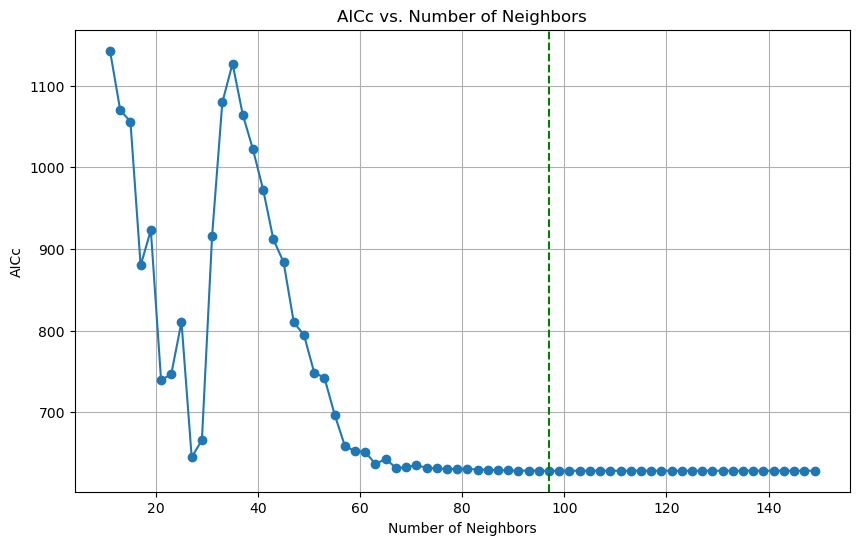

In [8]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(neighbors_values, aicc_values, marker='o')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.title('AICc vs. Number of Neighbors')
plt.grid(True)
plt.show()

In [9]:
len(enp_values), len(neighbors_values)

(70, 70)

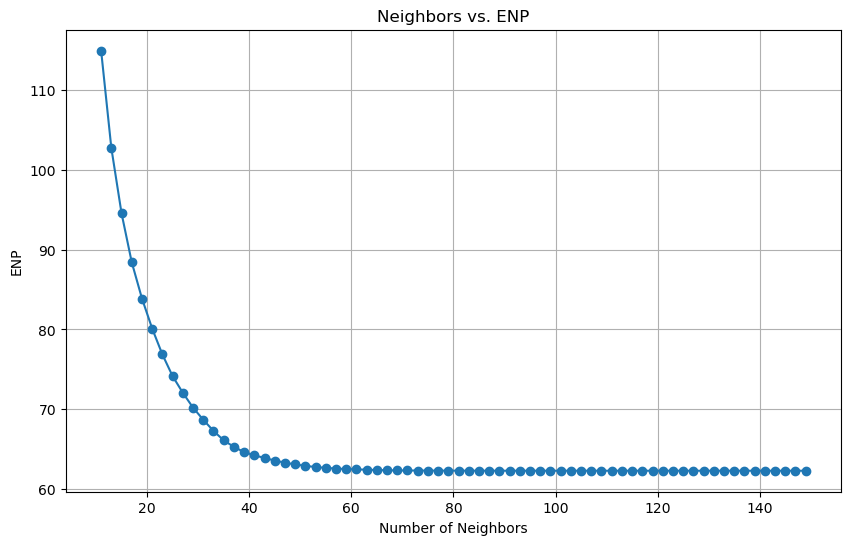

In [10]:

plt.figure(figsize=(10, 6))
plt.plot(neighbors_values, enp_values, marker='o')
plt.xlabel('Number of Neighbors')
plt.ylabel('ENP')
plt.title('Neighbors vs. ENP')
plt.grid(True)
plt.show()

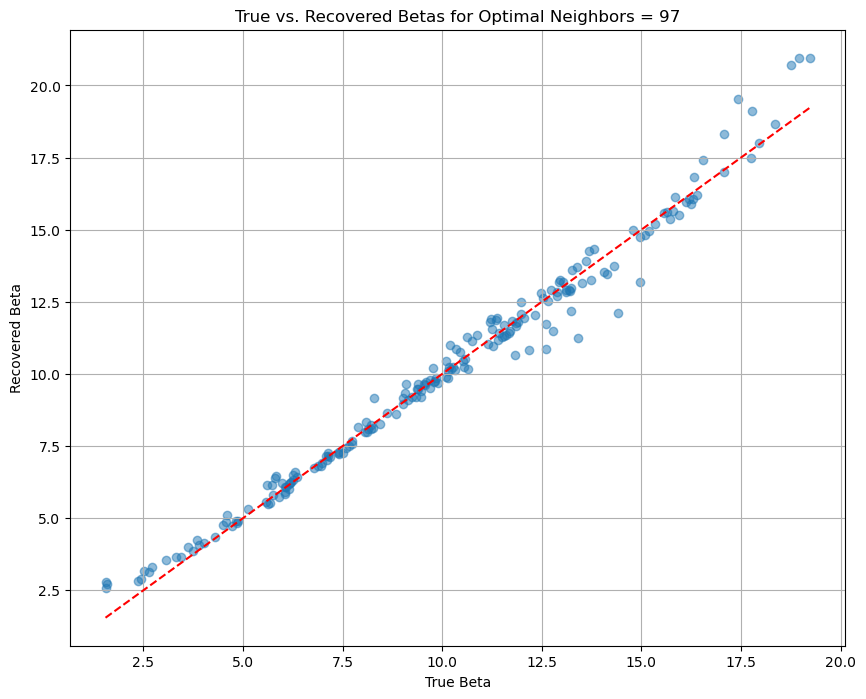

In [11]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, recovered_betas_best, alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f'True vs. Recovered Betas for Optimal Neighbors = {best_neighbors}')
plt.grid(True)
plt.show()

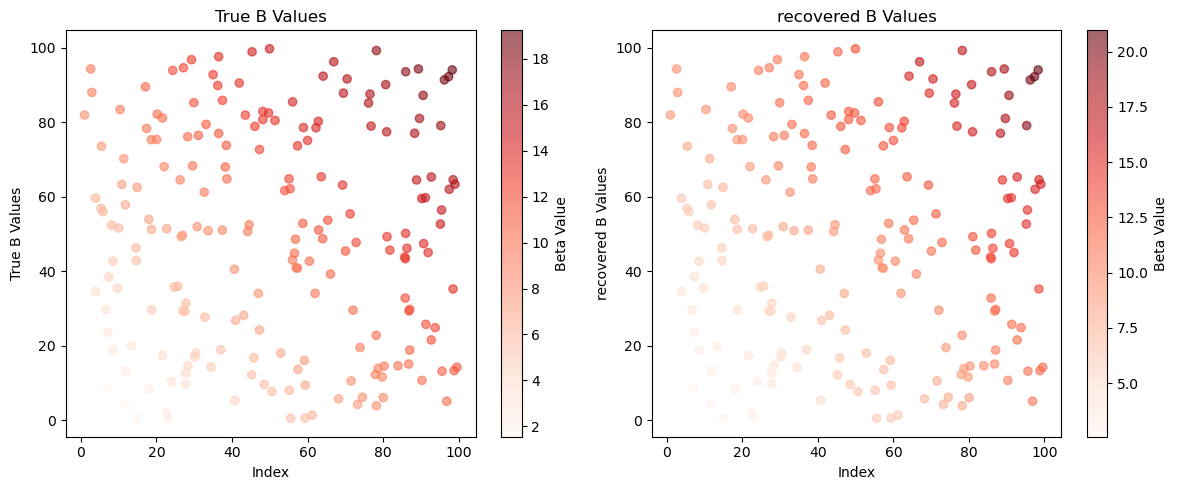

In [12]:
plot_true_and_recovered(B, recovered_betas_best, loc1)

## Test gwr recoverability 

In [13]:
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.diagnostics import get_AICc

In [14]:
gwr_X = smoothed_S2_to_S1.reshape(-1, 1)
gwr_y = y.reshape(-1, 1)
coords = loc1

In [15]:
selector = Sel_BW(coords, gwr_y, gwr_X, constant=True)
optimal_bandwidth = selector.search()
optimal_bandwidth

45.0

In [16]:
coords.shape, gwr_y.shape, gwr_X.shape

((200, 2), (200, 1), (200, 1))

In [17]:
gwr_model = GWR(coords, gwr_y, gwr_X, optimal_bandwidth, constant=False)

In [18]:
result = gwr_model.fit()

In [19]:
result.summary()

Model type                                                         Gaussian
Number of observations:                                                 200
Number of covariates:                                                     1

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                       31945783.736
Log-likelihood:                                                   -1481.911
AIC:                                                               2965.822
AICc:                                                              2967.883
BIC:                                                           31944729.371
R2:                                                                  -0.020
Adj. R2:                                                             -0.020

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [20]:
recovered_betas_gwr = result.params#[:,1]

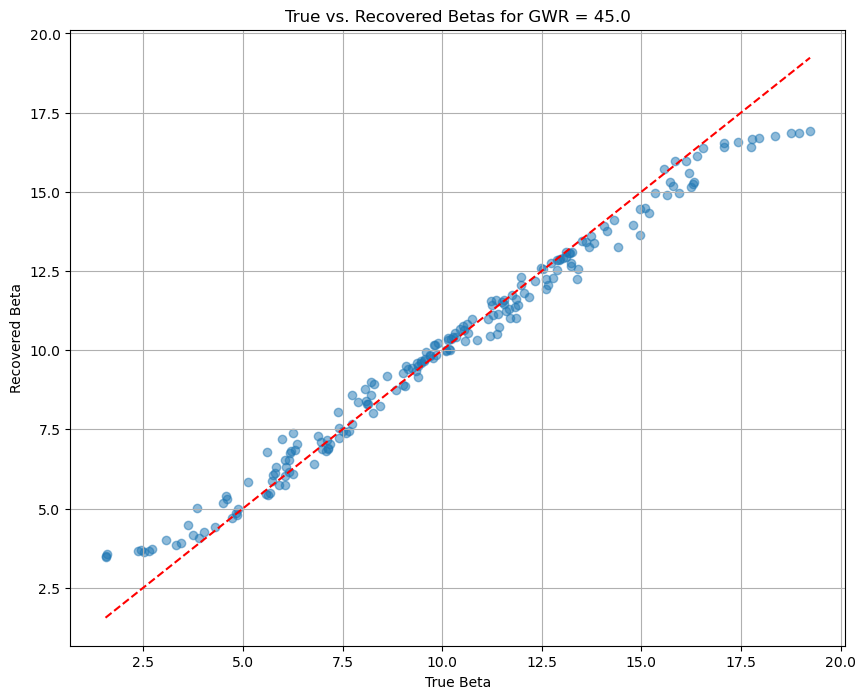

In [21]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors
plt.figure(figsize=(10, 8))
plt.scatter(B, recovered_betas_gwr, alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f'True vs. Recovered Betas for GWR = {optimal_bandwidth}')
plt.grid(True)
plt.show()

In [22]:
aicc_gwr = []
params = []
ENP = []
bwvalue = list(range(3, 60, 2))
for i in bwvalue:
    model = GWR(coords, gwr_y, gwr_X, i, constant=False).fit()
    params.append(model.params)
    aicc_gwr.append(model.aicc)
    ENP.append(model.ENP)

In [23]:
dict_aicc = dict(zip(bwvalue, aicc_gwr))

In [24]:
min(dict_aicc, key=dict_aicc.get)

9

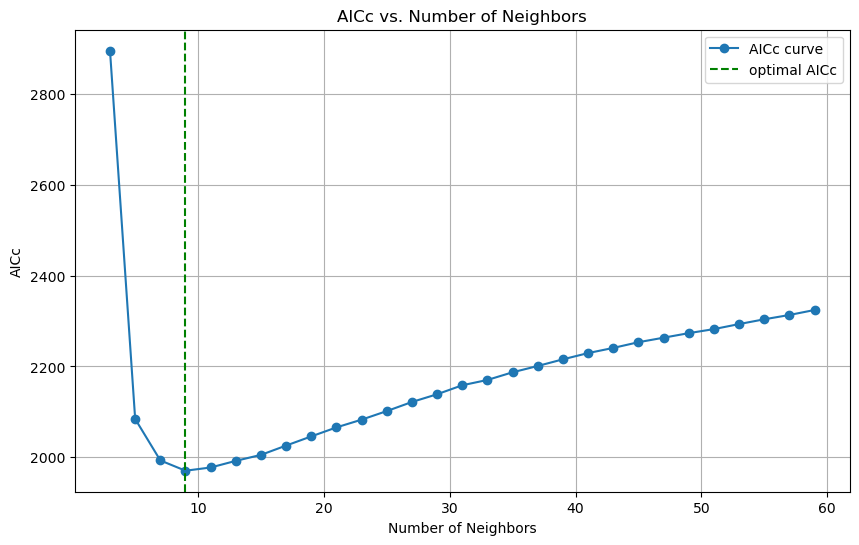

In [25]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(bwvalue, aicc_gwr, marker='o', label='AICc curve')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.legend()
plt.title('AICc vs. Number of Neighbors')
plt.grid(True)
plt.show()

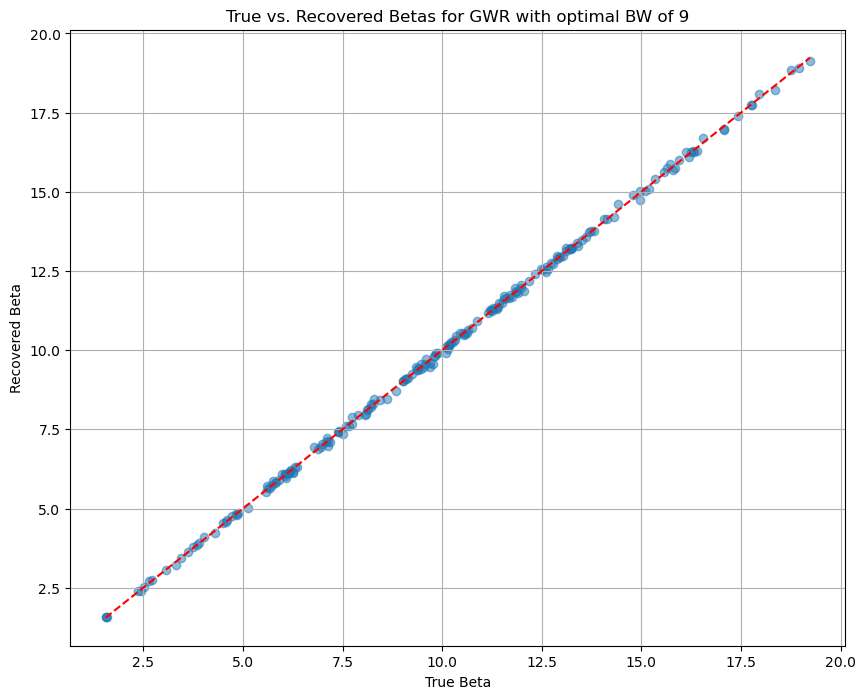

In [26]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors
plt.figure(figsize=(10, 8))
plt.scatter(B, params[0],
            alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f"True vs. Recovered Betas for GWR with optimal BW of {min(dict_aicc, key=dict_aicc.get)}")
plt.grid(True)
plt.show()

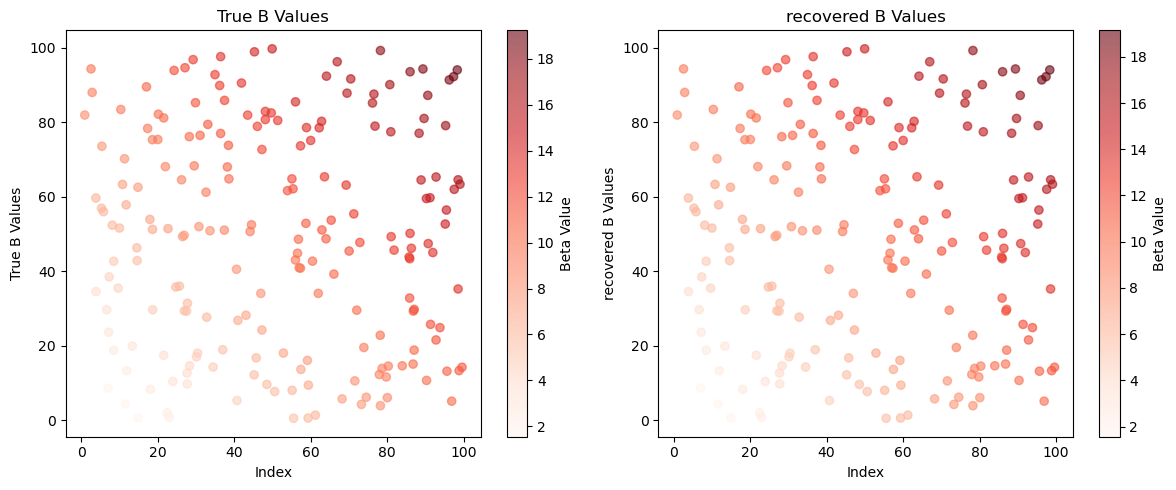

In [27]:
plot_true_and_recovered(B, params[0], loc1)